In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import time

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
from tqdm import tqdm

import utils
import metrics
import stein
import plot
from svgd import SVGD

rkey = random.PRNGKey(1)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# KL divergence estimation

## KL between two discrete probability vectors

Let $X_1, \dots, X_n$ iid as $q$ and $Y_1, \dots, Y_n$ iid as $p$. Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by

$$
\sum_{k=1}^K \hat q_k \log \frac{\hat q_k}{\hat p_k},
$$
where $\hat q$ and $\hat p$ are vectors in $\mathbb R^K$ representing histogram estimates of $q$ and $p$ with $K$ bins, computed using the samples $X_i$ and $Y_i$.

In [2]:
def get_bins_and_bincounts(samples, normalized=False):
    """take in samples, create a common set of bins, and compute the counts count(x in bin)
    for each bin and each sample x.
    Parameters
    ------------
    samples : np.array of shape (n,) or shape (k, n).
    - If shape (n,): interpreted as a set of n scalar-valued samples.
    - If shape (k, n): interpreted as k sets of n scalar-valued samples.
    
    Returns
    --------
    probabilities :
    bins :
    """
    nr_samples = np.prod(samples.shape)
    nr_bins = np.log2(nr_samples)
    nr_bins = int(max(nr_bins, 5))
    
    lims = [np.min(samples), np.max(samples)]
    bins = np.linspace(*lims, num=nr_bins)
    
    if samples.ndim == 2:
        out = np.asarray([np.histogram(x, bins=bins, density=normalized)[0] for x in samples])
        return out, bins
    elif samples.ndim == 1:
        return np.histogram(samples, bins=bins, density=normalized)[0], bins
    else:
        raise ValueError(f"Input must have shape (n,) or shape (k,n). Instead received shape {samples.shape}")
        
# get_bins_and_bincounts = jit(get_bins_and_bincounts)

In [3]:
def smooth_and_normalize(vec, normalize=True):
    """
    Parameters:
    * vec : np.array of shape (n,)
    * normalize : bool
    
    Returns:
    out : np.array of shape (n,).
    If vec_i = 0, then out_i = epsilon. If vec_i !=0, then out_i = vec_i - c.
    c is chosen such that sum(vec) == 1.
    """
    vec = np.asarray(vec, dtype=np.float32)
    
    if normalize:
        vec = vec / vec.sum()
    n = len(vec)
    epsilon = 0.0001
    num_nonzero = np.count_nonzero(vec)
    c = epsilon * (n - num_nonzero) / num_nonzero
    perturbation =  (vec == 0)*epsilon - (vec != 0)*c
    return vec + perturbation

In [4]:
def kl_from_probabilities(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=(k,)
    Discrete probability distributions. Can be unnormalized.
    """
    p = np.asarray(p, dtype=np.float32)
    q = np.asarray(q, dtype=np.float32)
    if p.shape != q.shape:
        raise ValueError("p and q need to have same shape.")
    elif p.ndim > 1:
        raise ValueError(f"Inputs need to be one-dimensional vectors.")
        
    p, q = [smooth_and_normalize(prob) for prob in (p, q)]
    
    return np.sum(p * np.log(p/q))

In [5]:
@jit
def kl_from_samples(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=(n,). iid samples from p and q.
    """
    samples = np.stack([p, q])
    vals, _ = get_bins_and_bincounts(samples)
    pprobs, qprobs = vals

    return kl_from_probabilities(pprobs, qprobs)

## KL between sample and continuous density

Let $X_1, \dots, X_n$ iid as $q$. Assume density $p$ is known. Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by

$$
1/n \sum_i \log \hat q(X_i) - \log p(X_i),
$$
where $\hat q$ is a histogram estimate of $q$ based on the samples $X_i$.

Note: this estimate is sensitive to the method used to determine the number of histogram bins $K$. Empirically, $K = \log_2(n)$ gives good results, while $K = n / 10$ or $K = \sqrt n$ don't.

In [6]:
def get_histogram_likelihoods(q):
    """
    Parameters:
    * q : np.array of scalar-valued samples from distribution q.
    
    Returns:
    np.array of same length as q, consisting of an approximation of the pdf q(x_i) at the samples x_i
    """
    q = np.asarray(q, dtype=np.float32)
    n = len(q) 
    
    bincounts, bins = get_bins_and_bincounts(q)
    bincounts = np.array(bincounts, dtype=np.int32)
    likelihoods = smooth_and_normalize(bincounts) / np.diff(bins)
    
    sample_probabilities = np.repeat(likelihoods, bincounts)
    return sample_probabilities

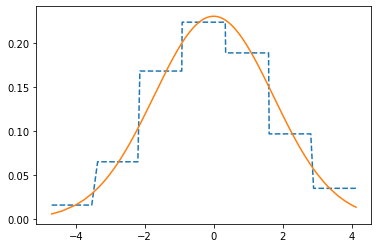

In [7]:
dist = metrics.Gaussian(0, 3)
s = dist.sample((500,))
sample_probabilities = get_histogram_likelihoods(s)
s = s.sort()
plt.plot(s, sample_probabilities, "--", label="histogram probabilities")
plt.plot(s, vmap(dist.pdf)(s), "-", label="true distribution")

In [8]:
np.sum(sample_probabilities[1:] * np.diff(s))

DeviceArray(1.0028296, dtype=float32)

In [9]:
def kl_sample_and_density(q, logp):
    """Kullback-Leibler divergence D(q || p) between sample p and cts density q
    Parameters
    ----------
    q : array-like, shape (d,). Samples from distribution q.
    logp : callable. Takes one argument, computes log(p(x))
    """
    histogram_likelihoods = get_histogram_likelihoods(q)
    return np.mean(np.log(histogram_likelihoods) - vmap(logp)(q))

## KL using interpolated CDF

A variation on the above approach. Let $X_1, \dots, X_n$ iid as $q$ and assume $p$ is known. Write $\mathbb Q_n$ for the empirical distribution of the $X_i$. Now define $\hat Q$ to be equal to $\mathbb Q_n$ when evaluated at one of the samples and linearly interpolated in between.

We can then approximate $q$ by the derivative $\hat q = \frac{d \hat Q}{dx}$. This is easy to evaluate since $\hat Q$ is piecewise linear.

Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by
$$
1/n \sum_{i=1}^n \log \frac{\hat q(X_i)}{p(X_i)}.
$$
Note that
$$
\hat q(X_i) = \frac{1/n}{X_i - X_{i-1}}.
$$

In [10]:
def get_interpolated_likelihoods(q):
    q = np.asarray(q, dtype=np.float32)
    n = len(q)
    
    diffs = np.diff(q.sort())
    diffs = smooth_and_normalize(diffs, normalize=False)
    pdf_estimate = 1 / n / diffs
    
    return np.concatenate([pdf_estimate[0, np.newaxis], pdf_estimate])

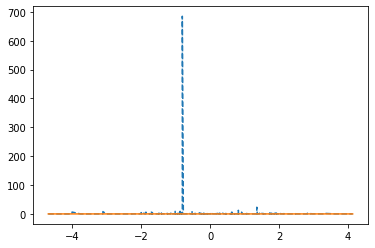

In [11]:
dist = metrics.Gaussian(0, 3)
s = dist.sample((500,))
sample_likelihoods = get_interpolated_likelihoods(s)
s = s.sort()
plt.plot(s, sample_likelihoods, "--", label="interpolated likelihoods")
plt.plot(s, vmap(dist.pdf)(s), "-", label="true distribution")

In [12]:
np.sum(sample_likelihoods[1:] * np.diff(s))

DeviceArray(0.99800014, dtype=float32)

In [13]:
def kl_using_interpolated_cdf(q, logp):
    """Kullback-Leibler divergence D(q || p) between sample p and cts density q
    Parameters
    ----------
    q : array-like, shape (d,). Samples from distribution q.
    logp : callable. Takes one argument, computes log(p(x))
    """
    histogram_likelihoods = get_interpolated_likelihoods(q)
    return np.mean(np.log(histogram_likelihoods) - vmap(logp)(q))

## Analytic KL of two Gaussians

This is the exact value for $\text{KL}(q \ \Vert \ p)$ where $q$ and $p$ are both Gaussian.

In [3]:
@jit
def kl_of_gaussian(p, q):
    """
    Parameters
    ----------
    p, q : array-like, parameters of gaussian: p = [mu, var], q = [mu2, var2]
    """
    mu1, var1 = p
    mu2, var2 = q
    sigma1, sigma2 = [np.sqrt(v) for v in (var1, var2)]
    out =  np.log(sigma2 / sigma1) + (var1 + (mu1 - mu2)**2) / (2 * var2) - 1/2
    return np.squeeze(out)

## KL estimate using fitted Gaussian parameters

In [15]:
def fit_gaussian(samples):
    """
    Parameters
    ----------
    samples : array-like, shape (n,)
    """
    samples = np.asarray(samples)
    return np.array([np.mean(samples), np.var(samples)])

## Test KL estimate for a range of sample sizes

In [16]:
def test_kl(qdist, pdist, ngrid, reps=1):
    """compute estimated KL(q || p) for a range of sample sizes"""
    ppars, qpars = [(dist.mean, dist.cov) for dist in (pdist, qdist)]
    
    kls_samples = []
    kls_sample_and_density = []
    kls_using_fit = []
    kls_interpolated = []
    for n in tqdm(ngrid):
        qs, ps = [dist.sample((n,)) for dist in (qdist, pdist)]
        
        kls_samples.append(kl_from_samples(qs, ps))
        kls_sample_and_density.append(kl_sample_and_density(qs, pdist.logpdf))
        kls_using_fit.append(kl_of_gaussian(fit_gaussian(qs), ppars))
        kls_interpolated.append(kl_using_interpolated_cdf(qs, pdist.logpdf))
        
    # true kl
    true_kl = kl_of_gaussian(qpars, ppars)
    return kls_samples, kls_sample_and_density, kls_using_fit, kls_interpolated, true_kl

def plot_results(ngrid, kls_samples, kls_sample_and_density, kls_using_fit, kls_interpolated, true_kl):
    fig, axs = plt.subplots(1, figsize=[10, 6])
    ax = axs
    ax.plot(ngrid, kls_samples, "--o", label="KL sample-sample")
    ax.plot(ngrid, kls_sample_and_density, "--o", label="KL sample-pdf")
    ax.plot(ngrid, kls_using_fit, "--o", label="KL using fitted gaussian")
    ax.plot(ngrid, kls_interpolated, "--o", label="KL using interpolated CDF")
    
    ax.set_xscale("log")
    ax.axhline(y=true_kl)
    ax.legend()

In [17]:
# parameters (mean, variance)
ppar = (0, 6)
qpar = (-5, 1)

pdist = metrics.Gaussian(*ppar)
qdist = metrics.Gaussian(*qpar)

ngrid = np.logspace(1, 3, 30)
ngrid = np.array(ngrid, dtype=np.int32)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [18]:
res = test_kl(qdist, pdist, ngrid)

100%|██████████| 30/30 [00:42<00:00,  1.40s/it]


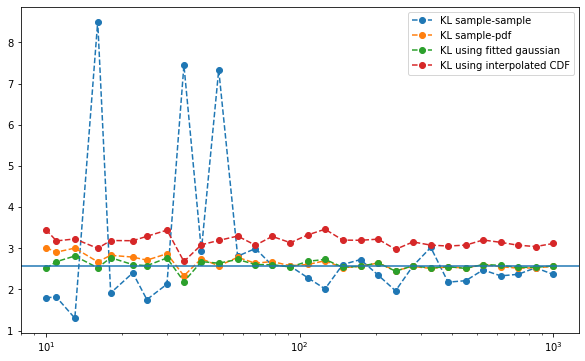

In [19]:
plot_results(ngrid, *res)

In [20]:
res[-1]

DeviceArray(2.5625465, dtype=float32)

## Implementation in `metrics.Distribution`

In [4]:
ppar = (0, 6) # (mean, variance)
qpar = (0, 1)

pdist = metrics.Gaussian(*ppar)
qdist = metrics.Gaussian(*qpar)

n = 100
sample = qdist.sample((n,))
print("KL estimate:", pdist.kl_divergence(sample))
print("True KL:", kl_of_gaussian(qpar, ppar))

KL estimate: 0.48759988
True KL: 0.4792131
